# Tidal modulation analysis in the Ridgecrest fault zone

This notebook reproduces the analysis of the tidal modulation of seismicity following the work described in Beaucé et al. (in review at BSSA) and using `seistides` v1.0.0 (see the last version at [https://github.com/ebeauce/seistides](https://github.com/ebeauce/seistides)).

First, download the earthquake catalog at:
[https://doi.org/10.5281/zenodo.18404896](https://doi.org/10.5281/zenodo.18404896)

Then, download the remaining auxiliary data, including the tidal stresses and distances to the fault, at:
[https://doi.org/10.5281/zenodo.18407428](https://doi.org/10.5281/zenodo.18407428)


Move all of the downloaded files to the `data` folder.


References
-----------
- Eric Beaucé, Piero Poli, Felix Waldhauser, Benjamin Holtzman and Christopher H. Scholz. Shift and increase in tidal modulation of seismicity in the Ridgecrest fault zone before and after the 2019 magnitude 7.1 earthquake. In review at Bulletin of Seismological Society of America.

In [183]:
%reload_ext autoreload
%autoreload 2

import os
import sys
HOME = os.path.expanduser("~")
ROOT = os.path.join(HOME, "")

import cartopy as ctp
import colorcet as cc
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as geopd
from tqdm import tqdm
from dateutil.relativedelta import relativedelta
import string

from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely import geometry
from scipy.signal import hilbert, resample_poly, wiener

import seistides

from subregions import select_subregion

plt.rcParams["savefig.dpi"] = 200
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["patch.force_edgecolor"] = False
pd.set_option('display.width', 1000)

In [184]:
PATH_DATA = "data"
CAT_PRE_FILENAME = "catalog_Ridgecrest_pre_mainshock.csv"
CAT_POST_FILENAME = "catalog_Ridgecrest_post_mainshock.csv"
DIST_TO_FAULT_PRE_FILENAME = "nearest_point_pre_mainshock.csv"
DIST_TO_FAULT_POST_FILENAME = "nearest_point_post_mainshock.csv"
TIDAL_STRESS_BASENAME = "tidal_stresses"

In [185]:
COLORS = {
    "fault_zone": "orange",
    "coso": "C0",
    "north": "grey",
    "foreshock_zone": "C1",
    "garlock": "C3",
}

## Load earthquake catalog

In [186]:
cat_pre_all = pd.read_csv(os.path.join(PATH_DATA, CAT_PRE_FILENAME), index_col=0)
# remove events that were identified as anthropogenic events
cat_pre_all = cat_pre_all[~(cat_pre_all["mining"] == True)]

cat_post_all = pd.read_csv(os.path.join(PATH_DATA, CAT_POST_FILENAME), index_col=0)
# I already removed the anthropogenic events from this catalog

## Select the sub-region of interest

In [187]:
REGION = "fault_zone"

if REGION in {"fault_zone", "foreshock_zone"}:
    dist_to_fault_pre = pd.read_csv(os.path.join(PATH_DATA, DIST_TO_FAULT_PRE_FILENAME), index_col=0)
    dist_to_fault_post = pd.read_csv(os.path.join(PATH_DATA, DIST_TO_FAULT_POST_FILENAME), index_col=0)

if REGION == "fault_zone":
    MAX_DIST_TO_FAULT_KM = 0.25 # this is the value used for Figure 7, but you should explore other values too
    cat_pre = select_subregion(cat_pre_all, REGION, width_km=MAX_DIST_TO_FAULT_KM, dist_to_fault=dist_to_fault_pre)
    cat_post = select_subregion(cat_post_all, REGION, width_km=MAX_DIST_TO_FAULT_KM, dist_to_fault=dist_to_fault_post)
elif REGION == "foreshock_zone":
    MAX_DIST_TO_FAULT_KM = 0.50 # this is the value used for Figure 7, but you should explore other values too
    cat_pre = select_subregion(cat_pre_all, REGION, width_km=MAX_DIST_TO_FAULT_KM, dist_to_fault=dist_to_fault_pre)
    cat_post = select_subregion(cat_post_all, REGION, width_km=MAX_DIST_TO_FAULT_KM, dist_to_fault=dist_to_fault_post)
elif REGION == "coso":
    cat_pre = select_subregion(cat_pre_all, REGION)
    cat_post = select_subregion(cat_post_all, REGION)
elif REGION == "garlock":
    cat_pre = select_subregion(cat_pre_all, REGION)
    cat_post = select_subregion(cat_post_all, REGION)
elif REGION == "north":
    cat_pre = select_subregion(cat_pre_all, REGION)
    cat_post = select_subregion(cat_post_all, REGION)
else:
    print("REGION should be one of {'fault_zone', 'foreshock_zone', 'coso', 'garlock', 'north'}")

There are 3380 earthquakes in the requested box.
There are 300757 earthquakes in the requested box.


## Plot the map of seismicity

In [188]:
# map parameters
M71 = {"longitude": -117.599, "latitude": 35.770, "depth": 8.0}
M64 = {"longitude": -117.504, "latitude": 35.705, "depth": 10.5}

LON_MIN, LON_MAX = -118.00, -117.20
LAT_MIN, LAT_MAX = 35.25, 36.25

central_lon = (LON_MIN + LON_MAX) / 2.0
central_lat = (LAT_MIN + LAT_MAX) / 2.0

data_coords = ctp.crs.PlateCarree()
projection = ctp.crs.Mercator(
    central_longitude=central_lon, min_latitude=LAT_MIN, max_latitude=LAT_MAX
)

# define inset extent
LON_MIN_INSET, LON_MAX_INSET = -113.88, -126.00
LAT_MIN_INSET, LAT_MAX_INSET = 32.19, 42.63
central_lon_inset = (LON_MIN_INSET + LON_MAX_INSET) / 2.0
central_lat_inset = (LAT_MIN_INSET + LAT_MAX_INSET) / 2.0

projection_inset = ctp.crs.Mercator(
    central_longitude=central_lon_inset,
    min_latitude=LAT_MIN_INSET,
    max_latitude=LAT_MAX_INSET,
)

In [189]:
# define colormap
cnorm_depth = Normalize(vmin=-2.0, vmax=20.0)
scalar_map_depth = ScalarMappable(norm=cnorm_depth, cmap=cc.cm.fire_r)
# scalar_map_depth = ScalarMappable(norm=cnorm_depth, cmap=plt.get_cmap("hot_r"))

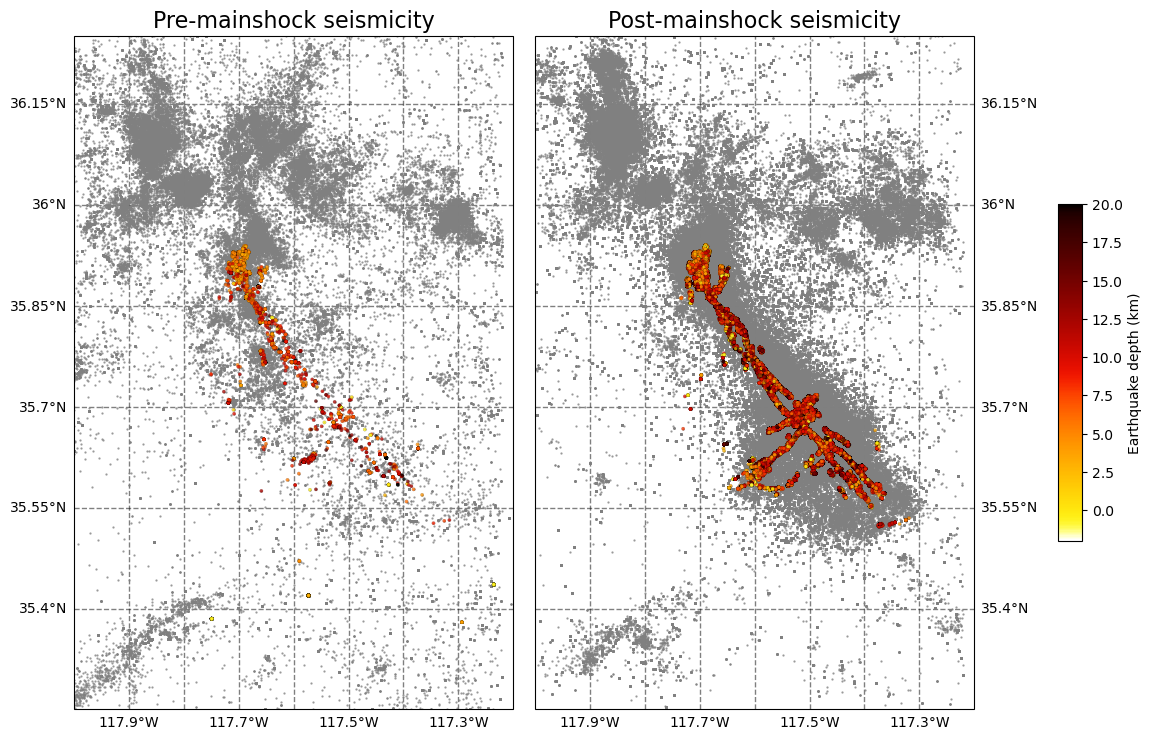

In [190]:
fig, axes = plt.subplots(
    num="map_seismicity", ncols=2, figsize=(12, 12),
    subplot_kw={"projection": projection},
    gridspec_kw={"wspace": 0.05, "right": 0.85, "left": 0.1}
    )

for i, ax in enumerate(axes):
    ax.set_rasterization_zorder(1)
    ax.set_extent([LON_MIN, LON_MAX, LAT_MIN, LAT_MAX], crs=data_coords)
    gl = ax.gridlines(
        draw_labels=True, linewidth=1, alpha=0.5, color="k", linestyle="--"
    )
    gl.top_labels = False
    gl.right_labels = False if i == 0 else True
    gl.left_labels = True if i == 0 else False
    # gl.bottom_labels = bottom_labels

# ----------------------------------------
# plot pre-mainshock seismicity
axes[0].set_title("Pre-mainshock seismicity", fontsize=16)

axes[0].scatter(
    cat_pre_all["longitude"],
    cat_pre_all["latitude"],
    s=0.4,
    color="grey",
    alpha=0.75,
    zorder=2,
    marker="o",
    rasterized=True,
    transform=data_coords,
)

axes[0].scatter(
    cat_pre["longitude"],
    cat_pre["latitude"],
    s=6,
    color=scalar_map_depth.to_rgba(cat_pre["depth"]),
    alpha=0.75,
    zorder=2,
    marker="o",
    edgecolor="k",
    linewidths=0.1,
    rasterized=True,
    transform=data_coords,
    label="Earthquakes"
)

# ----------------------------------------
# plot post-mainshock seismicity
axes[1].set_title("Post-mainshock seismicity", fontsize=16)

axes[1].scatter(
    cat_post_all["longitude"],
    cat_post_all["latitude"],
    s=0.4,
    color="grey",
    alpha=0.75,
    zorder=2,
    marker="o",
    rasterized=True,
    transform=data_coords,
)

axes[1].scatter(
    cat_post["longitude"],
    cat_post["latitude"],
    s=6,
    color=scalar_map_depth.to_rgba(cat_post["depth"]),
    alpha=0.75,
    zorder=2,
    marker="o",
    edgecolor="k",
    linewidths=0.1,
    rasterized=True,
    transform=data_coords,
    label="Earthquakes"
)

pos = axes[1].get_position()
cax = fig.add_axes([pos.x1 + 0.07, pos.y0 + 0.25 * pos.height, 0.02, 0.5 * pos.height])
plt.colorbar(scalar_map_depth, cax=cax, label="Earthquake depth (km)")

## Loda the tidal stresses

And compute the Coulomb stress for a given Skempton's coefficient.

In [191]:
TIDAL_STRESS_FILENAME = f"{TIDAL_STRESS_BASENAME}_{REGION}.h5"
SKEMPTON_COEFFICIENT = 0.50 # this is the value used in the paper, but you should explore other values between 0.50 and 0.90

NUM_BINS_PHASE = 25

In [192]:
STRESS_FIELDS = [
    "shear_stress",
    "normal_stress",
    "coulomb_stress",
    "volumetric_strain",
]
PHASE_FIELDS = [
    f"instantaneous_phase_{forcing.split('_')[0]}" for forcing in STRESS_FIELDS
]

In [193]:
tidal_stress = seistides.utils.load_tidal_stress(
    os.path.join(PATH_DATA, TIDAL_STRESS_FILENAME),
    fields=STRESS_FIELDS + ["volumetric_stress"],
    t_end="2025-01-01"
    )
if "volumetric_strain" in tidal_stress:
    # convert strain to nanostrain
    tidal_stress["volumetric_strain"] *= 1.e9

with h5.File(os.path.join(PATH_DATA, TIDAL_STRESS_FILENAME), mode="r") as fstress:
    # the following coefficient of friction was determined by the stress inversion
    # the results are not very sensitive to this value, so you could fix FRICTION_COEFFICIENT=0.6 for example
    FRICTION_COEFFICIENT = fstress["friction"][()]
tidal_stress["coulomb_stress"] = tidal_stress["coulomb_stress"] - FRICTION_COEFFICIENT * SKEMPTON_COEFFICIENT * tidal_stress["volumetric_stress"]

tidal_stress.drop(columns={"volumetric_stress"}, inplace=True)

In [194]:
# in its current form, the tidal stress time series have a sample time of 5min
# for a more accurate estimation of the duration of each phase bin, we upsample the time series by a factor of 10
UPSAMPLING_FACTOR = 10

dt = tidal_stress.index[1] - tidal_stress.index[0]
tidal_stress = tidal_stress.resample(dt / UPSAMPLING_FACTOR).interpolate("linear")
for forcing in STRESS_FIELDS:
    tidal_stress[forcing] = resample_poly(tidal_stress[forcing].values[::int(UPSAMPLING_FACTOR)], UPSAMPLING_FACTOR, 1, axis=0)[:len(tidal_stress)]

## Compute the instantaneous tidal phase

In [195]:
# approximate the semi-diurnal phase as the instantaneous phase
for stress_name, phase_name in zip(STRESS_FIELDS, PHASE_FIELDS):
    if stress_name in tidal_stress:
        analytical_signal = hilbert(tidal_stress[stress_name])
        tidal_stress[phase_name] = np.angle(analytical_signal, deg=True)

## Analysis of tidal modulation of seismicity

In [196]:
# define phase bins
PHASE_BINS = {}
for phase in PHASE_FIELDS:
    PHASE_BINS[phase] = np.linspace(-180., +180., NUM_BINS_PHASE+1)

In [197]:
# define the window parameters
SHORT_WINDOW_DAYS = 3 * 30
OVERLAP = 0.80
NUM_SHORT_WINDOWS = 64

LARGE_WINDOW_DURATION_DAYS = NUM_SHORT_WINDOWS*(1.-OVERLAP)*SHORT_WINDOW_DAYS + OVERLAP*SHORT_WINDOW_DAYS
print(f"Large window duration: {LARGE_WINDOW_DURATION_DAYS:.2f} days / {LARGE_WINDOW_DURATION_DAYS/365.:.2f} years")
LARGE_WINDOW_SHIFT = relativedelta(months=6)
WINDOW_TYPE = "backward"
WINDOW_DURATION = pd.Timedelta(days=LARGE_WINDOW_DURATION_DAYS)

Large window duration: 1224.00 days / 3.35 years


In [198]:
# measurement and modeling parameters
AGGREGATE = "median"
NUM_RESAMPLINGS = 50
MODEL = "exp"
if MODEL == "exp":
    OBJ_FUNCTION = "l2"
else:
    OBJ_FUNCTION = "negative-log-likelihood"

RATE_ESTIMATE_KWARGS = {
    "num_std_cutoff": 0.0,
    "num_bootstraps": 0,
    "bin_extension": 4,
    "cyclic_bins": True,
}
SVD_FILTERING_KWARGS = {
    "reconstruction_factor": 0.66,
}

FORCING_TYPES = [
    "instantaneous_phase_normal",
    "instantaneous_phase_coulomb",
    "instantaneous_phase_shear",
    "instantaneous_phase_volumetric",
]

In [199]:
seismicity_modulation = seistides.modulation.ModulationmeterMultiWindowForcingTimeBins(
    short_window_days=SHORT_WINDOW_DAYS,
    overlap=OVERLAP,
    num_short_windows=NUM_SHORT_WINDOWS,
    forcing=tidal_stress,
    forcing_bins=PHASE_BINS,
    window_type=WINDOW_TYPE
)

### Pre-mainshock analysis

In [200]:
seismicity_modulation.set_catalog(cat_pre)
seismicity_modulation.build_forcingtime_bins()
seismicity_modulation.count_events_in_forcingtime_bins()
seismicity_modulation.forcingtime_bins

{'instantaneous_phase_shear':        forcing_bin_membership  forcingtime_bin_starttime_sec  forcingtime_bin_duration_sec  forcingtime_bin_count
 0                          18                   1.199146e+09                         750.0                    0.0
 1                          19                   1.199146e+09                        1860.0                    0.0
 2                          20                   1.199148e+09                        1830.0                    0.0
 3                          21                   1.199150e+09                        1770.0                    0.0
 4                          22                   1.199152e+09                        1800.0                    0.0
 ...                       ...                            ...                           ...                    ...
 301173                     15                   1.735683e+09                        1590.0                    0.0
 301174                     16                   1.

In [201]:
T_START = pd.Timestamp("2008-01-01")

# ---------------------------------------------------------
#             pre-mainshock analysis
t_end = pd.Timestamp("2019-07-03")
t_start = t_end - WINDOW_DURATION

while t_end - WINDOW_DURATION > T_START:
    print(t_start.strftime("%Y-%m-%d"), "-", t_end.strftime("%Y-%m-%d"))
    for forcing_type in FORCING_TYPES:
        seismicity_modulation.measure_modulation(
            t_end,
            forcing_type,
            progress=False,
            window_type=seismicity_modulation.window_type,
            min_num_events_in_short_window=10,
            num_bootstrap_for_errors=NUM_RESAMPLINGS,
            aggregate=AGGREGATE,
            rate_estimate_kwargs=RATE_ESTIMATE_KWARGS,
            svd_filtering_kwargs=SVD_FILTERING_KWARGS,
        )
        if (forcing_type in seismicity_modulation.modulation) and (
            t_end in seismicity_modulation.modulation[forcing_type]
        ):
            # fit ratio
            seismicity_modulation.fit_modulation(
                seistides.models.fit_relative_rate_vs_phase_bootstrap,
                t_end,
                forcing_type,
                num_bootstraps=NUM_RESAMPLINGS,
                objective=OBJ_FUNCTION,
                model=MODEL,
                quantity="relative_rate",
                invert_norm=False
            )
            seismicity_modulation.evaluate_aic(
                t_end, forcing_type, model_name="model1", quantity="relative_rate",
            )

    t_start -= LARGE_WINDOW_SHIFT
    t_end -= LARGE_WINDOW_SHIFT

2016-02-25 - 2019-07-03
2015-08-25 - 2019-01-03
2015-02-25 - 2018-07-03
2014-08-25 - 2018-01-03
2014-02-25 - 2017-07-03
2013-08-25 - 2017-01-03
2013-02-25 - 2016-07-03
2012-08-25 - 2016-01-03
2012-02-25 - 2015-07-03
2011-08-25 - 2015-01-03
2011-02-25 - 2014-07-03
2010-08-25 - 2014-01-03
2010-02-25 - 2013-07-03
2009-08-25 - 2013-01-03
2009-02-25 - 2012-07-03
2008-08-25 - 2012-01-03
2008-02-25 - 2011-07-03


### Post-mainshock analysis

In [202]:
seismicity_modulation.set_catalog(cat_post)
seismicity_modulation.build_forcingtime_bins()
seismicity_modulation.count_events_in_forcingtime_bins()
seismicity_modulation.forcingtime_bins

{'instantaneous_phase_shear':        forcing_bin_membership  forcingtime_bin_starttime_sec  forcingtime_bin_duration_sec  forcingtime_bin_count
 0                          18                   1.199146e+09                         750.0                    0.0
 1                          19                   1.199146e+09                        1860.0                    0.0
 2                          20                   1.199148e+09                        1830.0                    0.0
 3                          21                   1.199150e+09                        1770.0                    0.0
 4                          22                   1.199152e+09                        1800.0                    0.0
 ...                       ...                            ...                           ...                    ...
 301173                     15                   1.735683e+09                        1590.0                    0.0
 301174                     16                   1.

In [203]:
T_START = pd.Timestamp("2019-08-01")

# ---------------------------------------------------------
#             pre-mainshock analysis
t_end = pd.Timestamp(seismicity_modulation.catalog["origin_time"].max())
t_start = t_end - WINDOW_DURATION

while t_end - WINDOW_DURATION > T_START:
    print(t_start.strftime("%Y-%m-%d"), "-", t_end.strftime("%Y-%m-%d"))
    for forcing_type in FORCING_TYPES:
        seismicity_modulation.measure_modulation(
            t_end,
            forcing_type,
            progress=False,
            window_type=seismicity_modulation.window_type,
            min_num_events_in_short_window=10,
            num_bootstrap_for_errors=NUM_RESAMPLINGS,
            aggregate=AGGREGATE,
            rate_estimate_kwargs=RATE_ESTIMATE_KWARGS,
            svd_filtering_kwargs=SVD_FILTERING_KWARGS,
        )
        if (forcing_type in seismicity_modulation.modulation) and (
            t_end in seismicity_modulation.modulation[forcing_type]
        ):
            # fit ratio
            seismicity_modulation.fit_modulation(
                seistides.models.fit_relative_rate_vs_phase_bootstrap,
                t_end,
                forcing_type,
                num_bootstraps=NUM_RESAMPLINGS,
                objective=OBJ_FUNCTION,
                model=MODEL,
                quantity="relative_rate",
                invert_norm=False
            )
            seismicity_modulation.evaluate_aic(
                t_end, forcing_type, model_name="model1", quantity="relative_rate",
            )

    t_start -= LARGE_WINDOW_SHIFT
    t_end -= LARGE_WINDOW_SHIFT

2021-02-23 - 2024-07-01
2020-08-23 - 2024-01-01
2020-02-23 - 2023-07-01
2019-08-23 - 2023-01-01


## Plot modulation vs time

Text(0.5, 1.0, 'Tidal modulation of seismicity in Fault_zone before and after the 2019 M7.1 Ridgecrest earthquake')

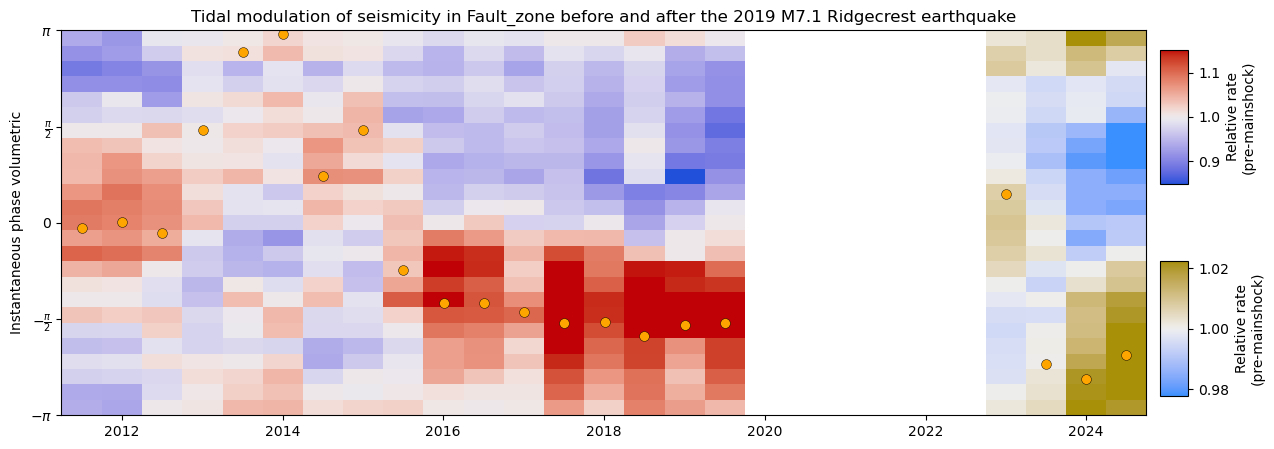

In [204]:
FORCING_TYPE = "instantaneous_phase_volumetric"
YTICK_LOC = [-180.0, -90.0, 0, 90.0, 180.0]
YTICK_LAB = [r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"]
WIENER_FILTER = [3, 3]

cmap = {"pre_mainshock": cc.cm.coolwarm, "post_mainshock": cc.cm.bwy}

fig, ax = plt.subplots(num=f"Ridgecrest_{FORCING_TYPE}", figsize=(14, 5))

midbins = seismicity_modulation.modulation[FORCING_TYPE][
    list(seismicity_modulation.modulation[FORCING_TYPE].keys())[0]
]["midbins"]
_, parameters, errors = seismicity_modulation.get_parameter_time_series(FORCING_TYPE)

forcing_data, time = seismicity_modulation.get_obs_vs_forcing_vs_time(FORCING_TYPE, "relative_rate")
before = time < pd.Timestamp("2019-07-04")
after = time >= pd.Timestamp("2019-08-01")


# test wiener filtering the data
half_wiener_win0 = WIENER_FILTER[0] // 2 + WIENER_FILTER[0] % 2
half_wiener_win1 = WIENER_FILTER[1] // 2 + WIENER_FILTER[1] % 2

# ----------------------------------------------------
#              before the mainshock
# ----------------------------------------------------
forcing_data_sm = np.pad(
        forcing_data[before, :],
        ((half_wiener_win0, half_wiener_win0), (half_wiener_win1, half_wiener_win1)),
        mode="edge"
        )
forcing_data_sm = wiener(forcing_data_sm, mysize=WIENER_FILTER)#, noise=0.01)
forcing_data_sm = forcing_data_sm[half_wiener_win0:-half_wiener_win0, half_wiener_win1:-half_wiener_win1]

vmax = np.percentile(forcing_data_sm, 97.5)
vmin = np.percentile(forcing_data_sm, 2.5)
vmax = max(abs(vmax - 1.), abs(vmin - 1.))
vmin = 1. - vmax
vmax = 1. + vmax

pc_before = ax.pcolormesh(
        time[before],
        midbins,
        # forcing_data_sm.T,
        forcing_data[before, :].T,
        cmap=cmap["pre_mainshock"],
        vmin=vmin,
        vmax=vmax,
        rasterized=True,
    )

# ----------------------------------------------------
#               after the mainshock
# ----------------------------------------------------
forcing_data_sm = np.pad(
        forcing_data[after, :],
        ((half_wiener_win0, half_wiener_win0), (half_wiener_win1, half_wiener_win1)),
        mode="edge"
        )
forcing_data_sm = wiener(forcing_data_sm, mysize=WIENER_FILTER)#, noise=0.01)
forcing_data_sm = forcing_data_sm[half_wiener_win0:-half_wiener_win0, half_wiener_win1:-half_wiener_win1]

vmax = np.percentile(forcing_data_sm, 97.5)
vmin = np.percentile(forcing_data_sm, 2.5)
vmax = max(abs(vmax - 1.), abs(vmin - 1.))
vmin = 1. - vmax
vmax = 1. + vmax

pc_after = ax.pcolormesh(
        time[after],
        midbins,
        # forcing_data_sm.T,
        forcing_data[after, :].T,
        cmap=cmap["post_mainshock"],
        vmin=vmin,
        vmax=vmax,
        rasterized=True,
    )

ax.scatter(
    time, np.rad2deg(parameters["phi"]), color=COLORS[REGION], edgecolor="k", s=50, linewidths=0.33
)

pos = ax.get_position()
cax_pre = fig.add_axes([pos.x1 + 0.01, pos.y0 + 0.60 * pos.height, 0.02, 0.35 * pos.height])
plt.colorbar(pc_before, cax=cax_pre, label="Relative rate\n(pre-mainshock)")

cax_post = fig.add_axes([pos.x1 + 0.01, pos.y0 + 0.05 * pos.height, 0.02, 0.35 * pos.height])
plt.colorbar(pc_after, cax=cax_post, label="Relative rate\n(pre-mainshock)")

ax.set_yticks(YTICK_LOC)
ax.set_yticklabels(YTICK_LAB)
ax.set_ylabel(FORCING_TYPE.replace("_", " ").capitalize())
ax.set_title(f"Tidal modulation of seismicity in {REGION.capitalize()} before and after the 2019 M7.1 Ridgecrest earthquake")